Reference:
1. https://medium.com/towards-data-science/efficient-image-segmentation-using-pytorch-part-1-89e8297a0923

In [10]:
from torchvision.datasets import OxfordIIITPet

pet_trainval = OxfordIIITPet(root="data", split="trainval", target_types="segmentation", download=True)
pet_test = OxfordIIITPet(root="data", split="test", target_types="segmentation", download=True)
pet_trainval, pet_test

(Dataset OxfordIIITPet
     Number of datapoints: 3680
     Root location: data,
 Dataset OxfordIIITPet
     Number of datapoints: 3669
     Root location: data)

tensor([1, 2, 3], dtype=torch.uint8)

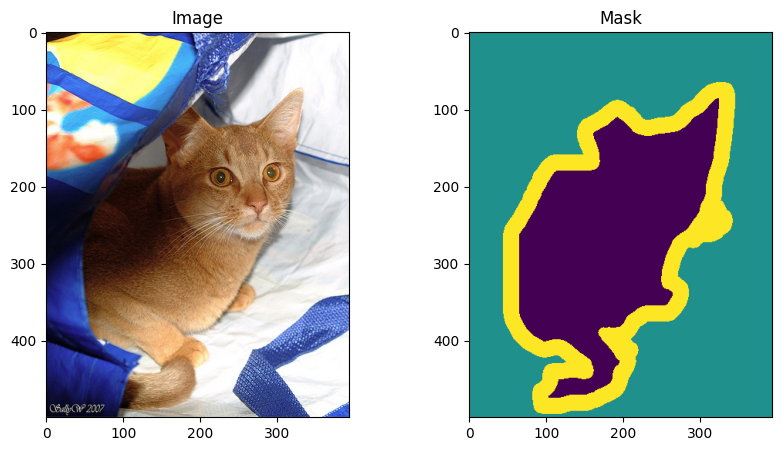

In [2]:
import matplotlib.pyplot as plt
from torch import unique
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor

image: Image = pet_trainval[0][0]
mask: Image = pet_trainval[0][1]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Image")

plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title("Mask")

unique(pil_to_tensor(mask)) # Trimap: 1=Pet, 2=Background, 3=Border

In [3]:
from torchinfo import summary
from torch.nn import Linear

model = Linear(1000, 500) # no # of parameters = 1000*500 (weights) + 500 (bias) = 500500
summary(
  model,
  input_size=(1, 1000),
  col_names=["kernel_size", "output_size", "num_params", "mult_adds"],
  col_width=15,
)

Layer (type:depth-idx)                   Kernel Shape    Output Shape    Param #         Mult-Adds
Linear                                   --              [1, 500]        500,500         500,500
Total params: 500,500
Trainable params: 500,500
Non-trainable params: 0
Total mult-adds (M): 0.50
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 2.00
Estimated Total Size (MB): 2.01

Reference:
1. https://medium.com/p/bed68cadd7c7

In [11]:
from importlib import reload
from src import oxford_iiit_pet_augmented, to_device, utils
reload(oxford_iiit_pet_augmented)
reload(to_device)
reload(utils)
OxfordIIITPetAugmented = oxford_iiit_pet_augmented.OxfordIIITPetAugmented
ToDevice = to_device.ToDevice
float_to_long = utils.float_to_long
get_device = to_device.get_device
from torchvision.transforms import (ToTensor, Compose, Resize, InterpolationMode, 
                                    RandomHorizontalFlip, ColorJitter, Lambda)

pre_transform = ToTensor()
pre_target_transform = ToTensor()
common_transform = Compose([
    ToDevice(get_device()),
    Resize((128, 128), interpolation=InterpolationMode.NEAREST),
    RandomHorizontalFlip(p=0.5)
])
post_transform = Compose([
    ColorJitter(contrast=0.3)
])
post_target_transform = Compose([
    Lambda(float_to_long)
])
pet_trainval = OxfordIIITPetAugmented(root="data", split="trainval", target_types="segmentation", 
                                      download=True, 
                                      pre_transform=pre_transform,
                                      pre_target_transform=pre_target_transform,
                                      common_transform=common_transform,
                                      post_transform=post_transform,
                                      post_target_transform=post_target_transform)
pet_test = OxfordIIITPetAugmented(root="data", split="test", target_types="segmentation",
                                  download=True,
                                  pre_transform=pre_transform,
                                  pre_target_transform=pre_target_transform,
                                  common_transform=common_transform,
                                  post_transform=post_transform,
                                  post_target_transform=post_target_transform)
pet_trainval, pet_test

(Dataset OxfordIIITPetAugmented
     Number of datapoints: 3680
     Root location: data
     StandardTransform
 Transform: ToTensor()
 Target transform: ToTensor(),
 Dataset OxfordIIITPetAugmented
     Number of datapoints: 3669
     Root location: data
     StandardTransform
 Transform: ToTensor()
 Target transform: ToTensor())

In [12]:
from torch.utils.data import DataLoader

pet_trainval_loader = DataLoader(pet_trainval, batch_size=64, shuffle=True)
pet_test_loader = DataLoader(pet_test, batch_size=21, shuffle=True)

pet_trainval_images, pet_trainval_masks = next(iter(pet_trainval_loader))
pet_test_images, pet_test_masks = next(iter(pet_test_loader))
pet_trainval_images.shape, pet_trainval_masks.shape, pet_test_images.shape, pet_test_masks.shape

(torch.Size([64, 3, 128, 128]),
 torch.Size([64, 1, 128, 128]),
 torch.Size([21, 3, 128, 128]),
 torch.Size([21, 1, 128, 128]))

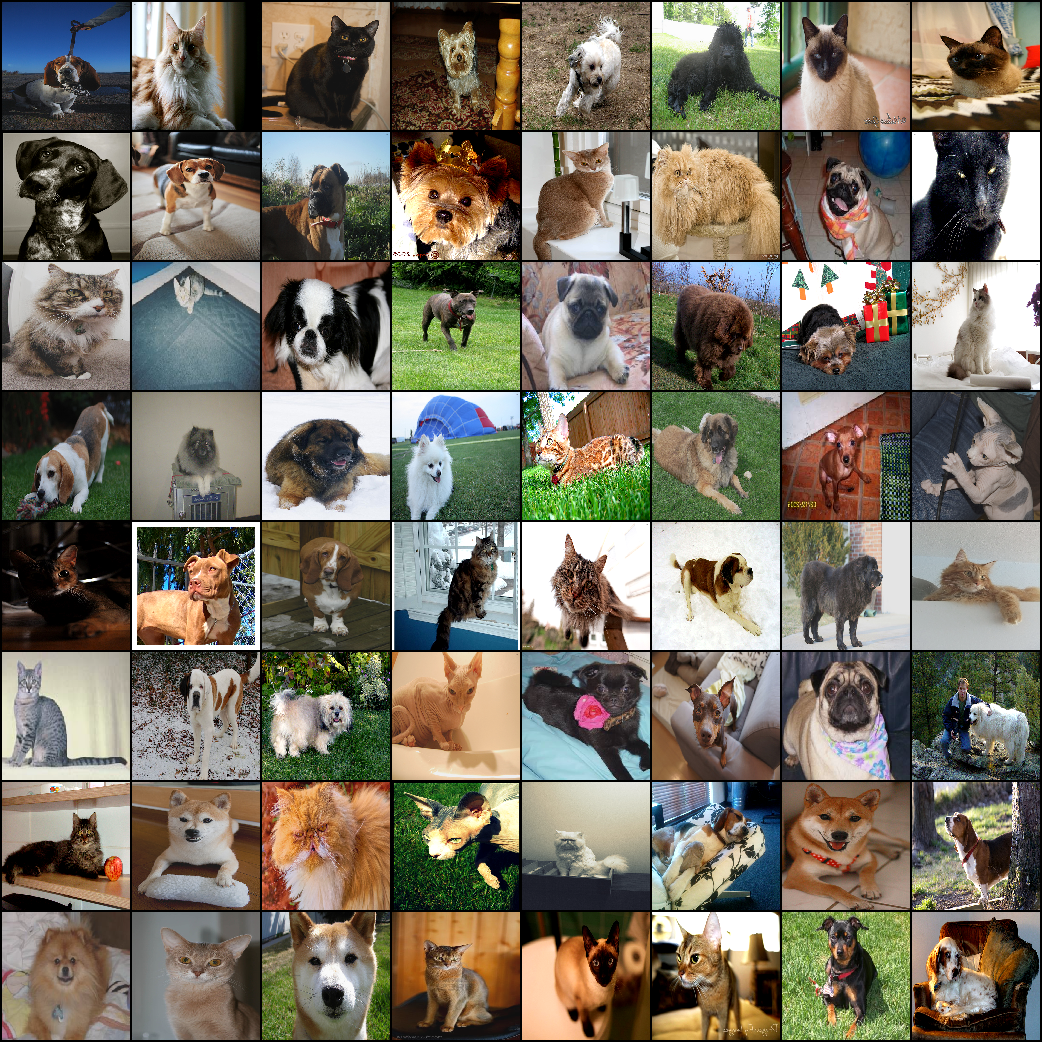

In [6]:
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage

ToPILImage()(make_grid(pet_trainval_images, nrow=8))

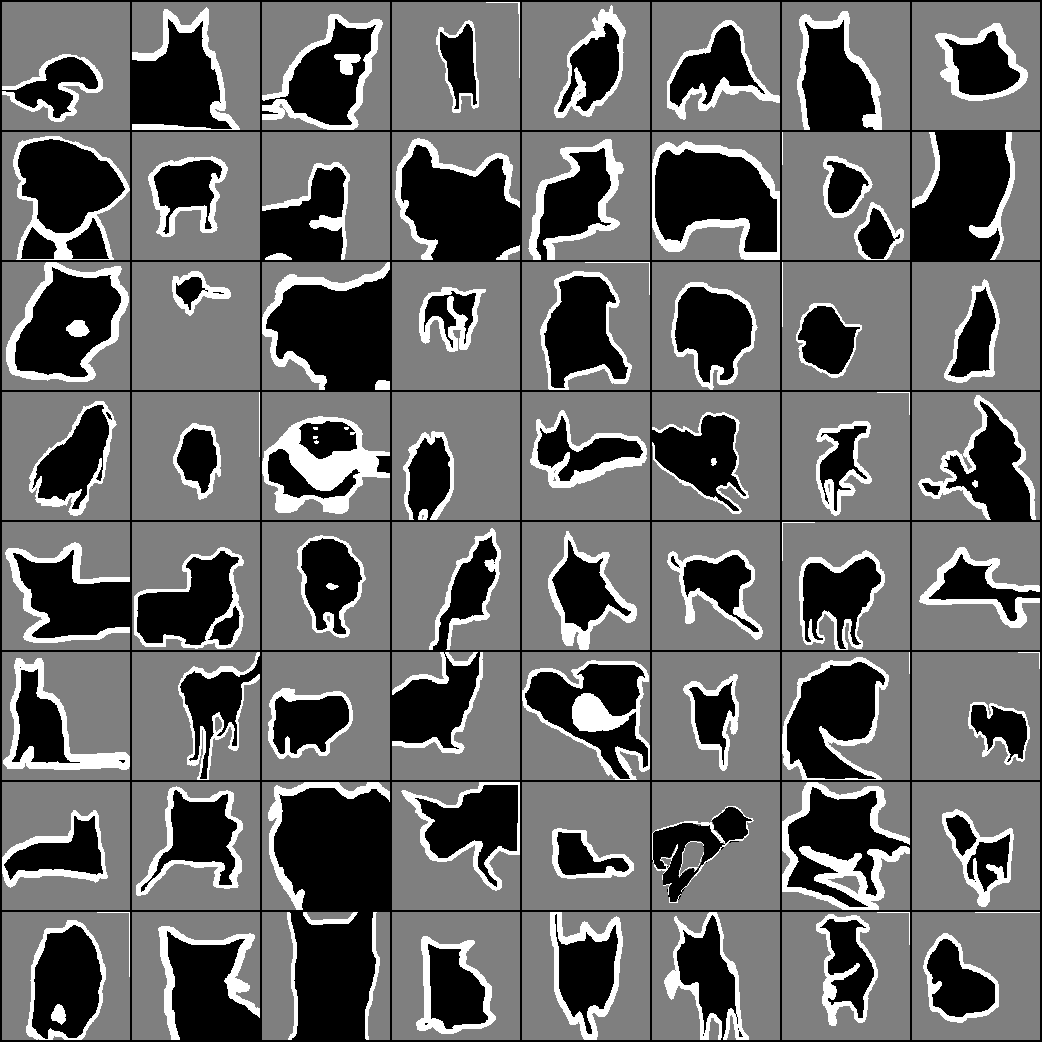

In [7]:
# input \in {0, 1, 2} -> divide by 2.0 to normalize to [0, 1]
ToPILImage()(make_grid(pet_trainval_masks / 2.0, nrow=8))

In [8]:
# Make sure the model is working
from importlib import reload
from src import seg_net, to_device
reload(seg_net)
reload(to_device)
ImageSegmentation = seg_net.ImageSegmentation
get_device = to_device.get_device

model = ImageSegmentation(num_classes=3, kernel_size=3)
model.eval()
device = get_device()
model.to(device)
model(pet_trainval_images.to(device)).shape

torch.Size([64, 3, 128, 128])

In [9]:
from importlib import reload
from src import iou_metric
reload(iou_metric)
IoULoss = iou_metric.IoULoss
from torch import rand, randint, long

def test_custom_iou_loss():
  #         N, C, H, W
  x = rand((2, 3, 2, 2), requires_grad=True)
  y = randint(0, 3, (2, 1, 2, 2), dtype=long)
  z = IoULoss(softmax=True)(x, y)
  return z

test_custom_iou_loss()

tensor(1.5817, grad_fn=<NegBackward0>)

# Model Training

Epoch: 01, Accuracy[Pixel: 0.2957, IoU: 0.5236, Custom IoU: 0.2000]


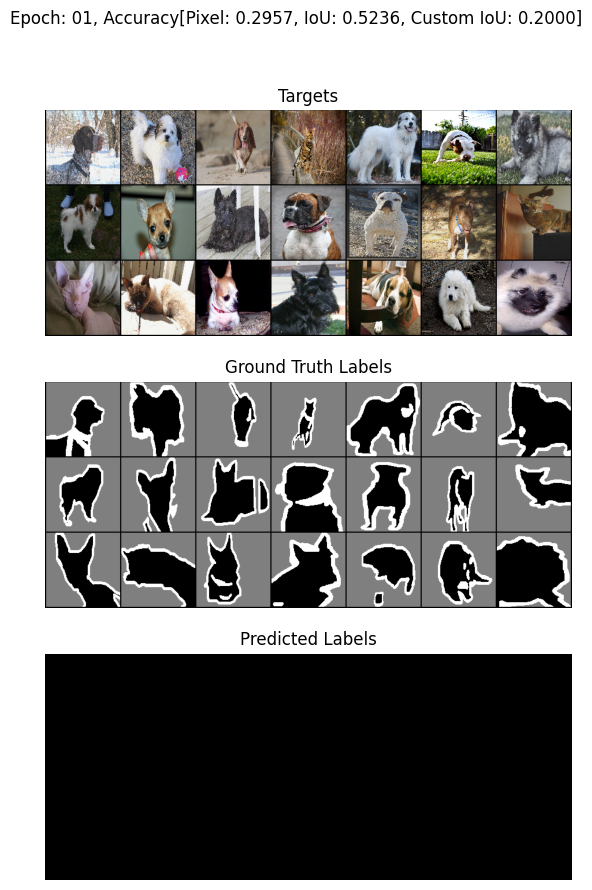

In [ ]:
import os
from importlib import reload
from src import train_model
reload(train_model)

evaluate_model = train_model.evaluate_model

# Check the function
evaluate_model(model, device, pet_test_images, pet_test_masks, epoch=1, root=None, show_plot=True)

In [11]:
from torch.optim import Adam, lr_scheduler

model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.7)

Epoch: 01, Learning Rate: [0.001]
Trained 3680 samples, Loss: 1.9523
Epoch: 01, Accuracy[Pixel: 0.6184, IoU: 0.4984, Custom IoU: 0.3107]

Epoch: 02, Learning Rate: [0.001]
Trained 3680 samples, Loss: 1.8006
Epoch: 02, Accuracy[Pixel: 0.6515, IoU: 0.4765, Custom IoU: 0.3239]

Epoch: 03, Learning Rate: [0.001]
Trained 3680 samples, Loss: 1.7556
Epoch: 03, Accuracy[Pixel: 0.7073, IoU: 0.5310, Custom IoU: 0.3535]

Epoch: 04, Learning Rate: [0.001]
Trained 3680 samples, Loss: 1.7082
Epoch: 04, Accuracy[Pixel: 0.7263, IoU: 0.4920, Custom IoU: 0.3547]

Epoch: 05, Learning Rate: [0.001]
Trained 3680 samples, Loss: 1.6725
Epoch: 05, Accuracy[Pixel: 0.6373, IoU: 0.5514, Custom IoU: 0.3498]

Epoch: 06, Learning Rate: [0.001]
Trained 3680 samples, Loss: 1.6326
Epoch: 06, Accuracy[Pixel: 0.6579, IoU: 0.5867, Custom IoU: 0.3815]

Epoch: 07, Learning Rate: [0.001]
Trained 3680 samples, Loss: 1.5941
Epoch: 07, Accuracy[Pixel: 0.7992, IoU: 0.6125, Custom IoU: 0.4438]

Epoch: 08, Learning Rate: [0.0007]

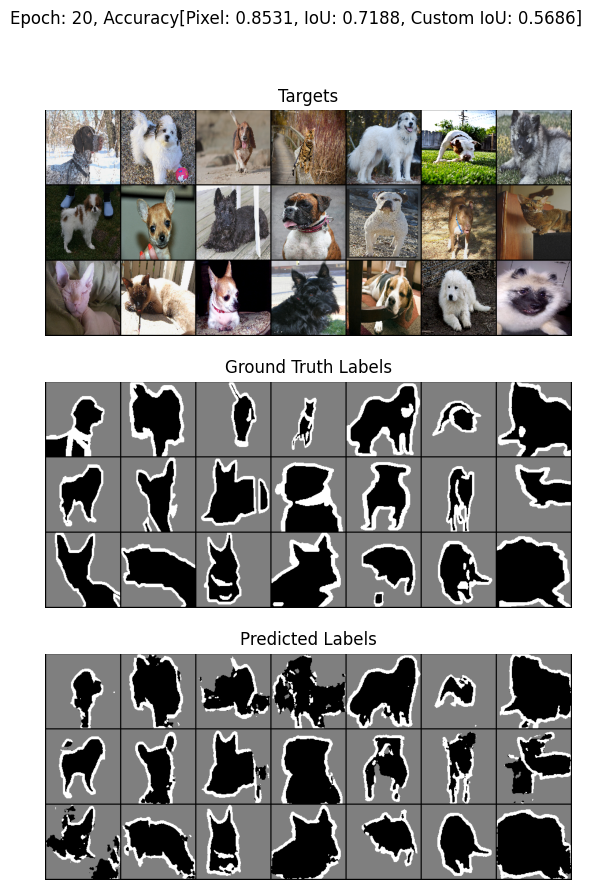

In [ ]:
from importlib import reload
from src import train_model
reload(train_model)
train_loop = train_model.train_loop

FOLDER_PATH = "progress/segnet"
os.makedirs(FOLDER_PATH, exist_ok=True)

# TODO: use all test set
train_loop(model=model, device=device, trainval_loader=pet_trainval_loader, 
           test_data=(pet_test_images, pet_test_masks), epochs=(1,21),
           optimizer=optimizer, scheduler=scheduler, root=FOLDER_PATH)

In [ ]:
from torch import save

save(model.state_dict(), f"{FOLDER_PATH}/model_epoch_20.pth")

In [15]:
print("Model parameters: {:.2f}M".format((sum(param.numel() for param in model.parameters())) / 1e6))

Model parameters: 15.27M


# SegNet Basic with depthwise-separable convolutions

In [26]:
from importlib import reload
from src import depthwise_separable_conv2d
reload(depthwise_separable_conv2d)
ImageSegmentationDSC = depthwise_separable_conv2d.ImageSegmentationDSC

# Check the model
mdsc = ImageSegmentationDSC(num_classes=3, kernel_size=3)
mdsc.eval()
mdsc.to(device)
mdsc(pet_trainval_images.to(device)).shape

torch.Size([64, 3, 128, 128])

In [27]:
print("Model parameters: {:.2f}M".format((sum(param.numel() for param in mdsc.parameters())) / 1e6))

Model parameters: 1.75M


Epoch: 01, Accuracy[Pixel: 0.2957, IoU: 0.5236, Custom IoU: 0.2000]


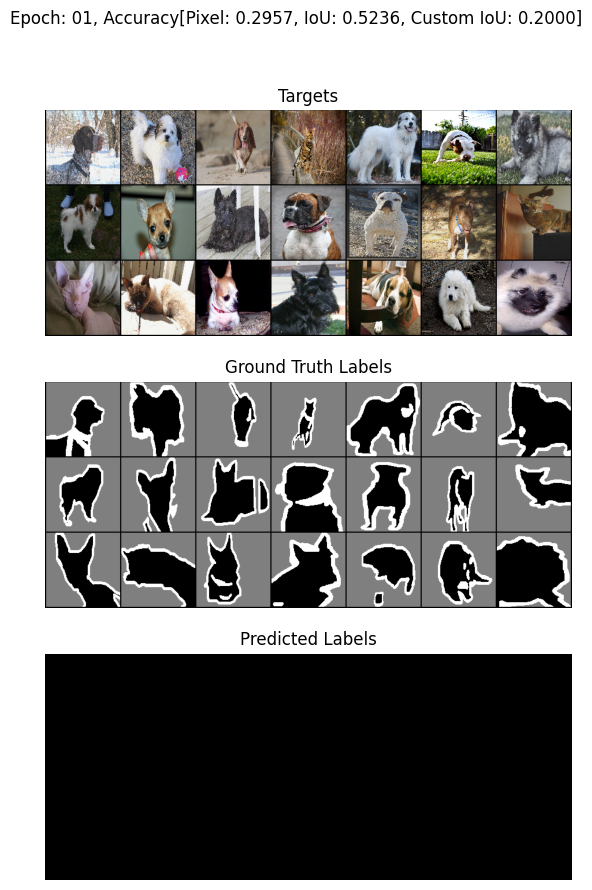

In [ ]:
# Check
evaluate_model(mdsc, device, pet_test_images, pet_test_masks, epoch=1, root=None, show_plot=True)

In [31]:
from torch.optim import Adam, lr_scheduler

optimizer2 = Adam(mdsc.parameters(), lr=0.001)
scheduler2 = None

Epoch: 01, Learning Rate: 0.001


Trained 3680 samples, Loss: 1.9194
Epoch: 01, Accuracy[Pixel: 0.6369, IoU: 0.5262, Custom IoU: 0.3339]

Epoch: 02, Learning Rate: 0.001
Trained 3680 samples, Loss: 1.7275
Epoch: 02, Accuracy[Pixel: 0.7477, IoU: 0.6308, Custom IoU: 0.3869]

Epoch: 03, Learning Rate: 0.001
Trained 3680 samples, Loss: 1.6626
Epoch: 03, Accuracy[Pixel: 0.7128, IoU: 0.6576, Custom IoU: 0.3780]

Epoch: 04, Learning Rate: 0.001
Trained 3680 samples, Loss: 1.6107
Epoch: 04, Accuracy[Pixel: 0.8167, IoU: 0.6443, Custom IoU: 0.4269]

Epoch: 05, Learning Rate: 0.001
Trained 3680 samples, Loss: 1.5724
Epoch: 05, Accuracy[Pixel: 0.8055, IoU: 0.6781, Custom IoU: 0.4434]

Epoch: 06, Learning Rate: 0.001
Trained 3680 samples, Loss: 1.5397
Epoch: 06, Accuracy[Pixel: 0.8466, IoU: 0.6347, Custom IoU: 0.4638]

Epoch: 07, Learning Rate: 0.001
Trained 3680 samples, Loss: 1.5081
Epoch: 07, Accuracy[Pixel: 0.8349, IoU: 0.7183, Custom IoU: 0.4854]

Epoch: 08, Learning Rate: 0.001
Trained 3680 samples, Loss: 1.4848
Epoch: 08, Ac

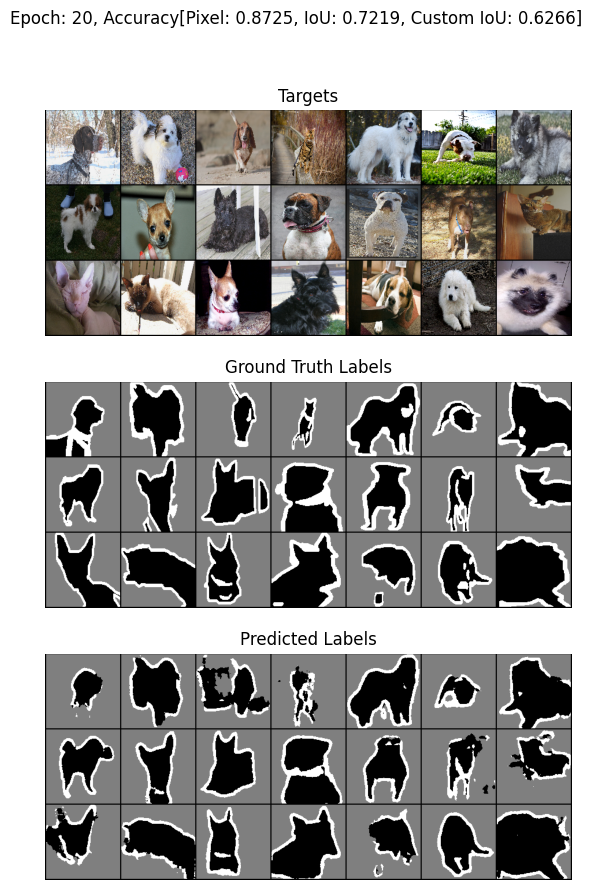

In [ ]:
from importlib import reload
from src import train_model
reload(train_model)
train_loop = train_model.train_loop

FOLDER_PATH2 = "progress/segnet_dsc"
os.makedirs(FOLDER_PATH2, exist_ok=True)

train_loop(model=mdsc, device=device, trainval_loader=pet_trainval_loader,
           test_data=(pet_test_images, pet_test_masks), epochs=(1,21),
           optimizer=optimizer2, scheduler=scheduler2, root=FOLDER_PATH2)

In [ ]:
from torch import save

save(mdsc.state_dict(), f"{FOLDER_PATH2}/weights/model_epoch_20.pth")

# Validate model accuracy on the complete test dataset

In [ ]:
from importlib import reload
from src import seg_net, depthwise_separable_conv2d
reload(seg_net)
reload(depthwise_separable_conv2d)
ImageSegmentation = seg_net.ImageSegmentation
ImageSegmentationDSC = depthwise_separable_conv2d.ImageSegmentationDSC
from torch import load

model = ImageSegmentation(num_classes=3, kernel_size=3)
model.load_state_dict(load(f"{FOLDER_PATH}/weights/model_epoch_20.pth"))

mdsc = ImageSegmentationDSC(num_classes=3, kernel_size=3)
mdsc.load_state_dict(load(f"{FOLDER_PATH2}/weights/model_epoch_20.pth"))

<All keys matched successfully>

In [13]:
from torch import inference_mode
from importlib import reload
from src import train_model, to_device
reload(train_model)
reload(to_device)
validate_model = train_model.validate_model
get_device = to_device.get_device

device = get_device()
with inference_mode():
  validate_model(model, device, pet_test_loader)
  validate_model(mdsc, device, pet_test_loader)

Model parameters: 15.27M


Test Dataset Accuracy
Pixel Accuracy: 0.8743, IoU Accuracy: 0.7096, Custom IoU Accuracy: 0.5916
Model parameters: 1.75M
Test Dataset Accuracy
Pixel Accuracy: 0.8761, IoU Accuracy: 0.7021, Custom IoU Accuracy: 0.6321


In [14]:
from torch.cuda import empty_cache

empty_cache()

# GIF visualization

In [ ]:
import os
import imageio
from PIL import Image

FOLDER_PATH = "progress/segnet_dsc"
images: list[float] = []
for file_name in sorted(os.listdir(f"{FOLDER_PATH}/epochs")):
  image = Image.open(f"{FOLDER_PATH}/epochs/{file_name}")
  image = image.resize((652, 950))
  images.append(image)
imageio.mimsave(f"{FOLDER_PATH}/epoch.gif", images)

In [ ]:
import os
import imageio
from PIL import Image

FOLDER_PATH = "progress/segnet_dsc"
images: list[float] = []
for file_name in sorted(os.listdir(f"{FOLDER_PATH}/epochs")):
  image = Image.open(f"{FOLDER_PATH}/epochs/{file_name}")
  image = image.resize((652, 950))
  images.append(image)
imageio.mimsave(f"{FOLDER_PATH}/epoch.gif", images)